# SM2 — Supply‑Air Heating (fresh − intake) & Ambient Context — Atrea (Public Dataset)

**Goal:** Provide clear, reproducible visuals explaining what the selected Atrea section looks like during summer, using the public dataset only.

### What this notebook shows
- **Chart 1 — Hourly “supply‑air heating” (fresh − intake) at a chosen local hour** for one Atrea section (e.g., `sm2_05`). This highlights how much the supply air is heated relative to intake air at that hour across days.
- **Chart 2 — Supply‑air heating vs ambient reference (robust overlay)** to see whether larger heating deltas happen on hotter or cooler days.

> _All times are handled in **Europe/Prague**; the raw dataset timestamps are **UTC**._

In [1]:
try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

plt.rcParams['figure.figsize'] = (12, 6)
OUT_DIR = Path('outputs'); OUT_DIR.mkdir(exist_ok=True)


## Load the public dataset (Parquet preferred)

This cell loads the single merged dataset (`sm2_public_dataset.parquet` or `csv.gz`) and derives local timestamps for Prague. It does not alter the data — only prepares `df` for the charts below.


In [2]:
PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"  # sm2_public_dataset.parquet
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"  # sm2_public_dataset.csv.gz
USE_PARQUET = True

parquet_path = Path('sm2_public_dataset.parquet')
csvgz_path   = Path('sm2_public_dataset.csv.gz')

def gdown_download(file_id: str, out_path: Path):
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'gdown'])
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print('Downloading Parquet…')
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print('Downloading CSV.GZ…')
        gdown_download(CSVGZ_ID, csvgz_path)

if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression='gzip')
else:
    raise FileNotFoundError('Dataset not found. Place it next to this notebook or enable internet to download.')

df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
df['local_time'] = df['time'].dt.tz_convert('Europe/Prague')
df['local_day'] = df['local_time'].dt.floor('D')
df['year'] = df['local_time'].dt.year
print('Shape:', df.shape)
df.head(3)


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 91.7MB/s]


Shape: (651332, 9)


,time,location,source,measurement,data_key,data_value,local_time,local_day,year
0,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_ambient,4.0,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023
1,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_fresh,20.3,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023
2,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_indoor,21.4,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023


## Optional: legacy → normalized location mapping

Public data already contain **normalized `location`** values. If you still have legacy labels somewhere, you can provide a `location_map.csv` (`from` → `to`) just to translate your own references. This does **not** change the dataset content.


In [3]:
raw2norm = {}
try:
    map_df = pd.read_csv('location_map.csv')
    if {'from','to'}.issubset(map_df.columns):
        raw2norm = dict(map_df[['from','to']].dropna().values)
        print('Loaded mapping rows:', len(raw2norm))
except Exception as e:
    print('Mapping not loaded (optional):', e)

def map_raw_locations(raw_list):
    if not raw2norm:
        return raw_list
    return [raw2norm.get(x, x) for x in raw_list]


Mapping not loaded (optional): [Errno 2] No such file or directory: 'location_map.csv'


## Parameters (what the charts will use)

- **`LOCATION`**: Atrea section to plot (e.g., `sm2_05`).  
- **`START_LOCAL`**: Lower bound of the window (local time).  
- **`HOUR_LOCAL`**: Local hour used to compute *supply‑air heating* (fresh − intake) as a single point per day.

Adjust these three to focus the visuals on a different section, date range, or hour of day.


In [4]:
LOCATION = 'sm2_03'          # normalized Atrea section
START_LOCAL = '2025-07-01 00:00:00'
HOUR_LOCAL = 6


## Chart 1 — Supply‑air heating (fresh − intake) at the selected local hour

For each day in the window, this chart shows **one value**: `temp_fresh − temp_intake` at `HOUR_LOCAL`.  
Interpretation:
- Higher values ⇒ **stronger heating** of supply air at that hour.
- Values near 0 ⇒ supply ≈ intake at that hour.
- A continuous sequence across days reveals whether the section tends to heat consistently or varies with weather/operation.

> _If no data exist exactly at the given hour for a day, that day simply won’t contribute a point._


data_key                   ohrev
local_time                      
2025-07-01 06:00:00+02:00    3.6
2025-07-02 06:00:00+02:00    3.3
2025-07-03 06:00:00+02:00    3.0
2025-07-04 06:00:00+02:00    3.1
2025-07-05 06:00:00+02:00    3.6


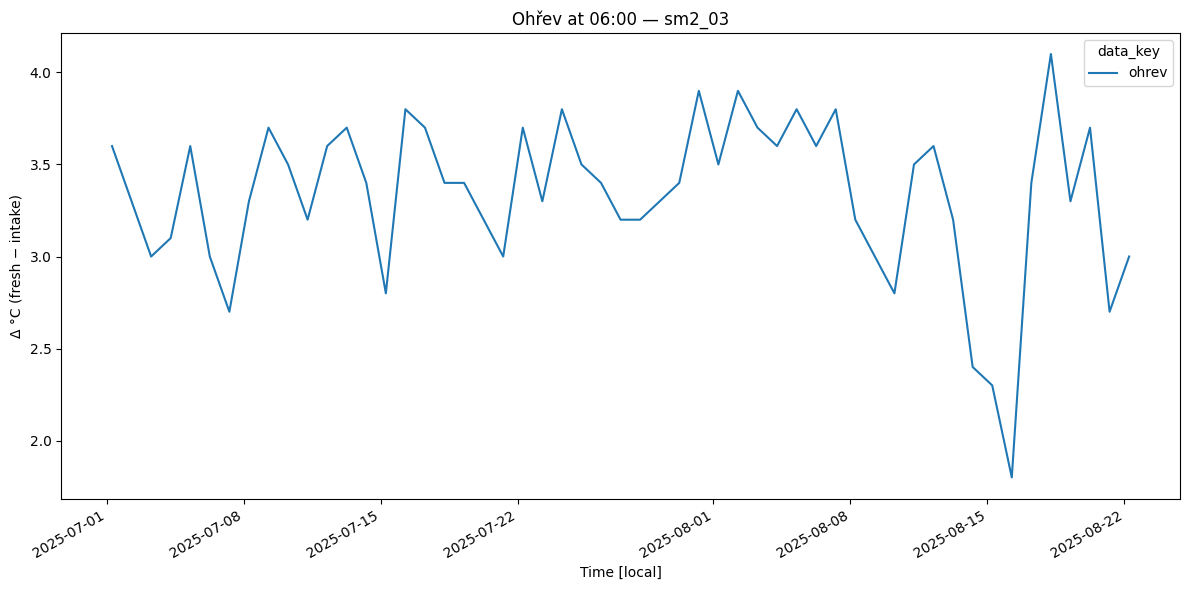

Saved: outputs/ohrev_sm2_03_6h.png


In [5]:
atr = df[(df['source']=='Atrea') & (df['location']==LOCATION)].copy()
atr = atr[atr['local_time'] >= pd.Timestamp(START_LOCAL, tz='Europe/Prague')]
atr['hour'] = atr['local_time'].dt.hour

keys_needed = ['temp_fresh','temp_intake','temp_ambient','temp_waste']
sub = atr[(atr['data_key'].isin(keys_needed)) & (atr['hour']==HOUR_LOCAL)].copy()

# Pivot to wide: index=local_time, columns=data_key
wide = sub.pivot_table(index='local_time', columns='data_key', values='data_value', aggfunc='mean').sort_index()
if wide.empty:
    print('No rows at the selected hour. Try a different HOUR_LOCAL or START_LOCAL.')
else:
    wide['ohrev'] = wide.get('temp_fresh') - wide.get('temp_intake')
    ohrev = wide[['ohrev']].dropna()
    print(ohrev.head())

    fig = plt.figure(); ax = plt.gca()
    ohrev.plot(ax=ax)
    ax.set_title(f"Ohřev at {HOUR_LOCAL:02d}:00 — {LOCATION}")
    ax.set_xlabel('Time [local]'); ax.set_ylabel('Δ °C (fresh − intake)')
    plt.tight_layout(); plt.savefig(OUT_DIR / f'ohrev_{LOCATION}_{HOUR_LOCAL}h.png', dpi=150); plt.show()
    print('Saved:', OUT_DIR / f'ohrev_{LOCATION}_{HOUR_LOCAL}h.png')


## Chart 2 — Supply‑air heating vs ambient reference (robust overlay)

To help interpret the heating delta in context, this overlay aligns **supply‑air heating** with **ambient** temperature using a robust matching strategy (nearest hour within a small tolerance; daily mean fallback; optional intake proxy if ambient is unavailable).  
What to look for:
- Whether **supply‑air heating** rises/falls together with **ambient** during the period.
- Days where **supply‑air heating** is high even when ambient is low (or the opposite), which may indicate operational settings (e.g., post-heating).


/tmp/ipython-input-572796933.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(pd.Grouper(freq='H')).mean())


Ambient overlay coverage: 53/53 (100%) | used_sitewide=True | daily_fallback=False | intake_proxy_used=False


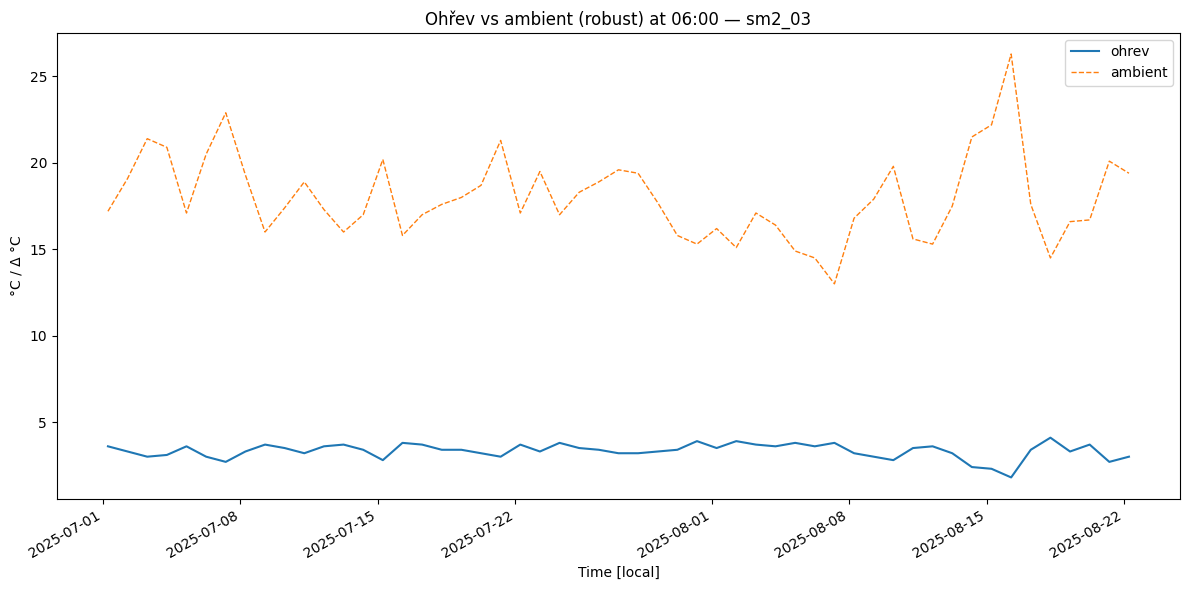

Saved: outputs/ohrev_vs_ambient_robust_sm2_03_6h.png


In [ ]:
# Ambient overlay with robust fallbacks:
# 1) Try section-level ambient at nearest hour (± tolerance)
# 2) If still missing, fall back to site-wide ambient daily mean for that day
# 3) If still missing, fall back to section intake at nearest hour as a proxy (clearly labeled)

AMBIENT_NEAREST_TOL_HOURS = 3  # adjust if you want a wider search window

def _prep_hourly_mean(frame):
    if frame.empty:
        return None
    s = (frame.set_index('local_time')['data_value']
               .sort_index()
               .resample('H').mean())
    return s

if not wide.empty and 'ohrev' in wide.columns:
    oh = wide[['ohrev']].dropna().copy()
    span_start = oh.index.min() - pd.Timedelta(hours=AMBIENT_NEAREST_TOL_HOURS)
    span_end   = oh.index.max() + pd.Timedelta(hours=AMBIENT_NEAREST_TOL_HOURS)

    # (A) Section-level ambient around the window
    amb_sec = df[(df['source']=='Atrea') & (df['data_key']=='temp_ambient') &
                 (df['location']==LOCATION) &
                 (df['local_time']>=span_start) & (df['local_time']<=span_end)].copy()
    amb_sec_hourly = _prep_hourly_mean(amb_sec)

    # (B) Site-wide ambient around the window (mean across sections)
    amb_all = df[(df['source']=='Atrea') & (df['data_key']=='temp_ambient') &
                 (df['local_time']>=span_start) & (df['local_time']<=span_end)].copy()
    amb_all_hourly = None
    if not amb_all.empty:
        amb_all_hourly = (amb_all.set_index('local_time')['data_value']
                                  .groupby(pd.Grouper(freq='H')).mean())

    # Choose series and align by nearest with tolerance
    amb_series = amb_sec_hourly if amb_sec_hourly is not None and not amb_sec_hourly.empty else amb_all_hourly
    used_sitewide = amb_series is amb_all_hourly

    if amb_series is not None and not amb_series.empty:
        amb_aligned = amb_series.reindex(oh.index, method='nearest',
                                         tolerance=pd.Timedelta(hours=AMBIENT_NEAREST_TOL_HOURS)).rename('ambient')
        aligned = oh.join(amb_aligned, how='left')
    else:
        aligned = oh.copy()
        aligned['ambient'] = pd.NA

    # (C) Daily-mean fallback for any remaining NaNs
    remaining = aligned['ambient'].isna()
    used_daily_fallback = False
    if remaining.any():
        # daily mean ambient across all sections
        if not amb_all.empty:
            amb_daily = (amb_all.set_index('local_time')['data_value']
                                .groupby(pd.Grouper(freq='D')).mean())
            # map each timestamp to its local day
            local_days = aligned.index.tz_convert('Europe/Prague').floor('D')
            aligned.loc[remaining, 'ambient'] = local_days[remaining].map(amb_daily)
            used_daily_fallback = aligned['ambient'].isna().sum() < remaining.sum()

    # (D) Intake proxy fallback (nearest) if still missing
    still_missing = aligned['ambient'].isna()
    used_intake_proxy = False
    if still_missing.any():
        intake = df[(df['source']=='Atrea') & (df['data_key']=='temp_intake') &
                    (df['location']==LOCATION) &
                    (df['local_time']>=span_start) & (df['local_time']<=span_end)].copy()
        intake_hourly = _prep_hourly_mean(intake)
        if intake_hourly is not None and not intake_hourly.empty:
            intake_aligned = intake_hourly.reindex(oh.index, method='nearest',
                                                   tolerance=pd.Timedelta(hours=AMBIENT_NEAREST_TOL_HOURS)).rename('intake_proxy')
            aligned = aligned.join(intake_aligned, how='left')
            used_intake_proxy = aligned['intake_proxy'].notna().any()

    # Report coverage
    total_pts = len(oh)
    amb_pts = aligned['ambient'].notna().sum()
    print(f"Ambient overlay coverage: {amb_pts}/{total_pts} ({amb_pts/total_pts:.0%})",
          f"| used_sitewide={bool(used_sitewide)}",
          f"| daily_fallback={bool(used_daily_fallback)}",
          f"| intake_proxy_used={bool(used_intake_proxy)}")

    # Plot
    fig = plt.figure(); ax = plt.gca()
    aligned[['ohrev']].plot(ax=ax)
    if amb_pts > 0:
        aligned[['ambient']].plot(ax=ax, linestyle='--', linewidth=1)
    elif used_intake_proxy and 'intake_proxy' in aligned.columns and aligned['intake_proxy'].notna().any():
        aligned[['intake_proxy']].plot(ax=ax, linestyle='--', linewidth=1)
        ax.legend(['ohrev','intake (proxy)'])
    ax.set_title(f"Ohřev vs ambient (robust) at {HOUR_LOCAL:02d}:00 — {LOCATION}")
    ax.set_xlabel('Time [local]'); ax.set_ylabel('°C / Δ °C')
    plt.tight_layout(); plt.savefig(OUT_DIR / f'ohrev_vs_ambient_robust_{LOCATION}_{HOUR_LOCAL}h.png', dpi=150); plt.show()
    print('Saved:', OUT_DIR / f'ohrev_vs_ambient_robust_{LOCATION}_{HOUR_LOCAL}h.png')
else:
    print('No ohřev series available — overlay skipped.')



### Notes
- You can change `LOCATION` to any Atrea section (`sm2_01`..`sm2_09`).  
- The visuals are **purely descriptive** — they show how much heating (fresh − intake) happens on the selected hour across days, and how it relates to ambient.  
- All calculations are simple aggregations over the public dataset; no proprietary preprocessing is required here.
